In [33]:
# Standard imports
import os
import time
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.utils as vutils
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader

In [34]:
# Set random seed and device
torch.manual_seed(1)
device = torch.device("cuda")
print('Device:', device)

Device: cuda


In [35]:
# Hyperparameters
LEARNING_RATE = 5e-5
BATCH_SIZE = 128
IMAGE_SIZE = 64
CHANNELS_IMG = 3
NOISE_DIM = 100
NUM_EPOCHS = 40
FEATURES_DISC = 64
FEATURES_GEN = 64
BETA1 = 0.5

In [36]:
# Create directories
os.makedirs('Results', exist_ok=True)
os.makedirs('Models', exist_ok=True)

In [37]:
# Dataset setup
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = datasets.CIFAR10(
    root="./dataset/CIFAR10data",
    download=True,
    transform=transform
)

dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)


Files already downloaded and verified


In [38]:
# Display training images
def display_training_images(dataloader, device):
    real_batch = next(iter(dataloader))
    plt.figure(figsize=(10,10))
    plt.axis("off")
    plt.title("Training Images")
    plt.imshow(np.transpose(
        vutils.make_grid(real_batch[0].to(device)[:32], padding=2, normalize=True).cpu(),
        (1,2,0)
    ))

In [39]:
# Display training images
def display_training_images(dataloader, device):
    real_batch = next(iter(dataloader))
    plt.figure(figsize=(10,10))
    plt.axis("off")
    plt.title("Training Images")
    plt.imshow(np.transpose(
        vutils.make_grid(real_batch[0].to(device)[:32], padding=2, normalize=True).cpu(),
        (1,2,0)
    ))

class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)

class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            self._block(channels_noise, features_g * 16, 4, 1, 0),
            self._block(features_g * 16, features_g * 8, 4, 2, 1),
            self._block(features_g * 8, features_g * 4, 4, 2, 1),
            self._block(features_g * 4, features_g * 2, 4, 2, 1),
            nn.ConvTranspose2d(features_g * 2, channels_img, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels, momentum=0.9),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)

def initialize_weights(model):
    """Initialize model weights to normal distribution with mean=0, std=0.02"""
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [40]:
# Model initialization
generator = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
discriminator = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
initialize_weights(generator)
initialize_weights(discriminator)

In [41]:
# Optimizers
gen_optimizer = optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(BETA1, 0.999))
disc_optimizer = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(BETA1, 0.999))

In [42]:
# Loss function
criterion = nn.BCELoss()

# Fixed noise for visualization
fixed_noise = torch.randn(32, NOISE_DIM, 1, 1).to(device)

In [43]:
# Set models to training mode
generator.train()
discriminator.train()

Discriminator(
  (disc): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
    (6): Sigmoid()
  )
)

In [ ]:
class InceptionV3(nn.Module):
   """Pretrained InceptionV3 network for FID calculation"""
   DEFAULT_BLOCK_INDEX = 3
   BLOCK_INDEX_BY_DIM = {64: 0, 192: 1, 768: 2, 2048: 3}

   def __init__(self, output_blocks=[DEFAULT_BLOCK_INDEX], resize_input=True, 
                normalize_input=True, requires_grad=False):
       super(InceptionV3, self).__init__()
       self.resize_input = resize_input
       self.normalize_input = normalize_input
       self.output_blocks = sorted(output_blocks)
       self.last_needed_block = max(output_blocks)

       assert self.last_needed_block <= 3, 'Last possible output block index is 3'

       self.blocks = nn.ModuleList()
       inception = models.inception_v3(pretrained=True)

       # Input to maxpool1
       block0 = [
           inception.Conv2d_1a_3x3,
           inception.Conv2d_2a_3x3,
           inception.Conv2d_2b_3x3,
           nn.MaxPool2d(kernel_size=3, stride=2)
       ]
       self.blocks.append(nn.Sequential(*block0))

       # Maxpool1 to maxpool2
       if self.last_needed_block >= 1:
           block1 = [
               inception.Conv2d_3b_1x1,
               inception.Conv2d_4a_3x3,
               nn.MaxPool2d(kernel_size=3, stride=2)
           ]
           self.blocks.append(nn.Sequential(*block1))

       # Maxpool2 to aux classifier
       if self.last_needed_block >= 2:
           block2 = [
               inception.Mixed_5b,
               inception.Mixed_5c,
               inception.Mixed_5d,
               inception.Mixed_6a,
               inception.Mixed_6b,
               inception.Mixed_6c,
               inception.Mixed_6d,
               inception.Mixed_6e,
           ]
           self.blocks.append(nn.Sequential(*block2))

       # Aux classifier to final avgpool
       if self.last_needed_block >= 3:
           block3 = [
               inception.Mixed_7a,
               inception.Mixed_7b,
               inception.Mixed_7c,
               nn.AdaptiveAvgPool2d(output_size=(1, 1))
           ]
           self.blocks.append(nn.Sequential(*block3))

       for param in self.parameters():
           param.requires_grad = requires_grad

   def forward(self, inp):
       outp = []
       x = inp

       if self.resize_input:
           x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)

       if self.normalize_input:
           x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

       for idx, block in enumerate(self.blocks):
           x = block(x)
           if idx in self.output_blocks:
               outp.append(x)
           if idx == self.last_needed_block:
               break

       return outp

In [45]:
def calculate_activation_statistics(images, model, batch_size=128, dims=2048, cuda=True):
   """Calculate activation statistics for FID score"""
   model.eval()
   activations = np.empty((len(images), dims))
   
   batch = images.cuda() if cuda else images
   predictions = model(batch)[0]
   if predictions.size(2) != 1 or predictions.size(3) != 1:
       predictions = adaptive_avg_pool2d(predictions, output_size=(1, 1))

   activations = predictions.cpu().data.numpy().reshape(predictions.size(0), -1)
   
   mu = np.mean(activations, axis=0)
   sigma = np.cov(activations, rowvar=False)
   return mu, sigma

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
   """Calculate Frechet distance between two distributions"""
   mu1 = np.atleast_1d(mu1)
   mu2 = np.atleast_1d(mu2)
   sigma1 = np.atleast_2d(sigma1)
   sigma2 = np.atleast_2d(sigma2)

   assert mu1.shape == mu2.shape, 'Training and test mean vectors have different lengths'
   assert sigma1.shape == sigma2.shape, 'Training and test covariances have different dimensions'

   diff = mu1 - mu2
   covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
   
   if not np.isfinite(covmean).all():
       msg = f'fid calculation produces singular product; adding {eps} to diagonal of cov estimates'
       print(msg)
       offset = np.eye(sigma1.shape[0]) * eps
       covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

   if np.iscomplexobj(covmean):
       if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
           m = np.max(np.abs(covmean.imag))
           raise ValueError(f'Imaginary component {m}')
       covmean = covmean.real

   tr_covmean = np.trace(covmean)
   return diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean

def calculate_fid(real_images, fake_images, model):
   """Calculate FID score between real and fake images"""
   mu_real, std_real = calculate_activation_statistics(real_images, model, cuda=True)
   mu_fake, std_fake = calculate_activation_statistics(fake_images, model, cuda=True)
   fid_value = calculate_frechet_distance(mu_real, std_real, mu_fake, std_fake)
   return fid_value

In [46]:
def save_training_results(gen_losses, disc_losses, fid_scores, img_list):
   """Save and plot training results"""
   # Create directories if they don't exist
   os.makedirs('Results/Loss_Data', exist_ok=True)
   os.makedirs('Results/FID_score', exist_ok=True)
   
   # Save losses and FID scores
   np.save('Results/Loss_Data/DCGAN_GLoss', gen_losses)
   np.save('Results/Loss_Data/DCGAN_DLoss', disc_losses)
   np.save('Results/FID_score/DC_FID', fid_scores)
   
   # Plot and save loss curves
   plt.figure(figsize=(10,5))
   plt.title("Generator and Discriminator Loss During Training")
   plt.plot(gen_losses, label="Generator")
   plt.plot(disc_losses, label="Discriminator")
   plt.xlabel("Iterations")
   plt.ylabel("Loss")
   plt.legend()
   plt.savefig('Results/loss.png', format='png', bbox_inches='tight')
   plt.close()
   
   # Plot and save FID scores
   plt.figure(figsize=(10,5))
   plt.title("FID Scores for DCGAN")
   plt.plot(fid_scores, label="DCGAN")
   plt.xlabel("Epochs")
   plt.ylabel("FID")
   plt.legend()
   plt.savefig('Results/FID.png', format='png', bbox_inches='tight')
   plt.close()
   
   # Plot real vs fake images
   plot_real_vs_fake_images(dataloader, img_list[-1], device)

def plot_real_vs_fake_images(dataloader, final_fake_images, device):
   """Plot and save real vs generated images"""
   real_batch = next(iter(dataloader))
   plt.figure(figsize=(15,15))
   
   plt.subplot(1,2,1)
   plt.axis("off")
   plt.title("Real Images")
   plt.imshow(np.transpose(vutils.make_grid(
       real_batch[0].to(device)[:32], padding=5, normalize=True).cpu(),(1,2,0)))
   
   plt.subplot(1,2,2)
   plt.axis("off")
   plt.title("Fake Images")
   plt.imshow(np.transpose(final_fake_images,(1,2,0)))
   
   plt.savefig('Results/DCGAN30_BEST_FAKE_32.png', format='png', bbox_inches='tight')
   plt.close()

In [47]:
# Initialize FID model
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
inception_model = InceptionV3([block_idx]).to(device)

# Training initialization
generator_losses = []
discriminator_losses = []
generated_images = []
fid_scores = []
iterations = 0

c:\Users\elrod\anaconda3\envs\DeepLearning\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\elrod\anaconda3\envs\DeepLearning\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [48]:
print("Starting Training...")
training_start_time = time.time()

for epoch in range(NUM_EPOCHS):
   for batch_idx, (real_images, _) in enumerate(dataloader):
       real_images = real_images.to(device)
       current_batch_size = real_images.size(0)
       
       # Train Discriminator
       noise = torch.randn(current_batch_size, NOISE_DIM, 1, 1).to(device)
       fake_images = generator(noise)
       
       disc_real = discriminator(real_images).reshape(-1)
       disc_real_loss = criterion(disc_real, torch.ones_like(disc_real))
       disc_fake = discriminator(fake_images.detach()).reshape(-1)
       disc_fake_loss = criterion(disc_fake, torch.zeros_like(disc_fake))
       disc_loss = (disc_real_loss + disc_fake_loss) / 2
       
       disc_optimizer.zero_grad()
       disc_loss.backward()
       disc_optimizer.step()

       # Train Generator
       gen_output = discriminator(fake_images).reshape(-1)
       gen_loss = criterion(gen_output, torch.ones_like(gen_output))
       
       gen_optimizer.zero_grad()
       gen_loss.backward()
       gen_optimizer.step()

       # Record losses
       generator_losses.append(gen_loss.detach().cpu())
       discriminator_losses.append(disc_loss.detach().cpu())

       # Save generated images periodically
       if (iterations % 500 == 0) or ((epoch == NUM_EPOCHS-1) and (batch_idx == len(dataloader)-1)):
           with torch.no_grad():
               test_images = generator(fixed_noise).detach().cpu()
           generated_images.append(vutils.make_grid(test_images, padding=2, normalize=True))
       
       iterations += 1
   
   # Calculate FID score for epoch
   fid_score = calculate_fid(real_images, fake_images, inception_model)
   fid_scores.append(fid_score)
   
   # Progress reporting
   if epoch % 5 == 0:
       print(f'Epoch [{epoch+1}/{NUM_EPOCHS}] Batch {batch_idx}/{len(dataloader)} '
             f'Loss D: {disc_loss:.3f}, Loss G: {gen_loss:.3f} FID: {fid_score:.3f}')
   
   # Save generated and real images
   os.makedirs('Results/DCGAN_FAKE', exist_ok=True)
   os.makedirs('Results/DCGAN_REAL', exist_ok=True)
   
   with torch.no_grad():
       fake_samples = generator(fixed_noise)
       vutils.save_image(fake_samples.detach(),
                        f'Results/DCGAN_FAKE/DCGAN50_epoch_{epoch:03d}.png',
                        normalize=True)
       vutils.save_image(real_images.detach(),
                        f'Results/DCGAN_REAL/DCGAN50_epoch_{epoch:03d}.png',
                        normalize=True)

training_time = time.time() - training_start_time
print(f'\nTraining completed in {training_time:.2f} seconds')

Starting Training...
Epoch [1/40] Batch 390/391 Loss D: 0.075, Loss G: 3.793 FID: 411.815
Epoch [6/40] Batch 390/391 Loss D: 0.668, Loss G: 0.892 FID: 363.824
Epoch [11/40] Batch 390/391 Loss D: 0.680, Loss G: 0.763 FID: 298.977
Epoch [16/40] Batch 390/391 Loss D: 0.525, Loss G: 1.180 FID: 268.048
Epoch [21/40] Batch 390/391 Loss D: 0.650, Loss G: 0.931 FID: 249.349
Epoch [26/40] Batch 390/391 Loss D: 0.721, Loss G: 0.844 FID: 230.679
Epoch [31/40] Batch 390/391 Loss D: 0.659, Loss G: 1.112 FID: 225.739
Epoch [36/40] Batch 390/391 Loss D: 0.674, Loss G: 0.728 FID: 220.857

Training completed in 1685.27 seconds


In [49]:
# Save and plot final results
save_training_results(generator_losses, discriminator_losses, fid_scores, generated_images)


Final Statistics:
Generator Loss - Mean: 1.0839, Min: 0.4767, Final: 0.8545
Discriminator Loss - Mean: 0.5980, Min: 0.0011, Final: 0.6332
FID Scores - Min: 213.8687, Max: 447.9960, Mean: 276.8337, Final: 216.1531


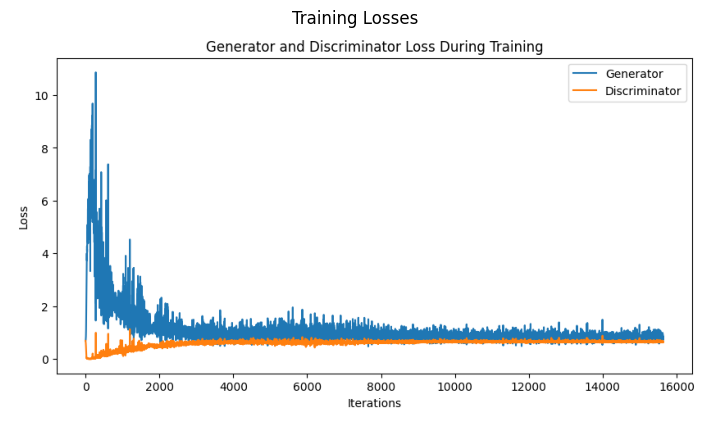

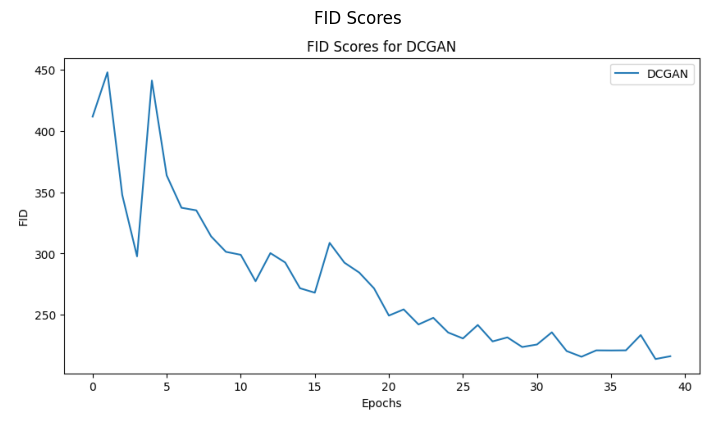

In [51]:
# Print final statistics
print("\nFinal Statistics:")
print(f"Generator Loss - Mean: {np.mean(generator_losses):.4f}, Min: {np.min(generator_losses):.4f}, Final: {generator_losses[-1]:.4f}")
print(f"Discriminator Loss - Mean: {np.mean(discriminator_losses):.4f}, Min: {np.min(discriminator_losses):.4f}, Final: {discriminator_losses[-1]:.4f}")
print(f"FID Scores - Min: {np.min(fid_scores):.4f}, Max: {np.max(fid_scores):.4f}, Mean: {np.mean(fid_scores):.4f}, Final: {fid_scores[-1]:.4f}")

plt.figure(figsize=(10,5))
img = plt.imread('Results/loss.png')
plt.imshow(img)
plt.axis('off')
plt.title("Training Losses")
plt.show()

plt.figure(figsize=(10,5))
img = plt.imread('Results/FID.png')
plt.imshow(img)
plt.axis('off')
plt.title("FID Scores")
plt.show()